# 3. Covid-19 Cases and Deaths Feature Engineering and Modeling

This notebook continues from the last notebook, beginning by importing the cleaned and merged COVID-19 cases, vaccination and patient impact data to begin modeling. The purpose of this notebook is to use this data to model and predict future Covid-19 cases and deaths. 

## 3.1 Library Imports

In [1]:
# Uncomment the following lines to install the necessary libraries

#! pip install gspread-pandas
#! pip install darts
#! pip install xgboost

In [2]:
import os
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
import xgboost as xgb
from IPython.display import Markdown as md
import gspread_pandas
from darts import TimeSeries, concatenate
from darts.utils.missing_values import fill_missing_values
from darts.models import NaiveSeasonal, RegressionModel,  ARIMA, ExponentialSmoothing, TBATS, AutoARIMA
from darts.utils.statistics import plot_acf, check_seasonality
from darts.utils.timeseries_generation import datetime_attribute_timeseries, constant_timeseries
from darts.metrics import mase, mae

## 3.2 Data Import

We begin by importing the cleaned Covid-19 data. We aggregate the data by the 'Date' column so we have an overall count of the US population Data that we can use in a timeseries forecasting model.

In [3]:
covid_df = pd.read_csv('../clean_data/merge_covid.csv', index_col=0)

In [4]:
covid_df = covid_df.sort_values('date')

In [5]:
covid_df.head()

,state,date,critical_staffing_shortage_today_yes,critical_staffing_shortage_today_no,critical_staffing_shortage_today_not_reported,critical_staffing_shortage_anticipated_within_week_yes,critical_staffing_shortage_anticipated_within_week_no,inpatient_beds_used_covid,inpatient_beds_used_covid_coverage,previous_day_admission_adult_covid_confirmed,...,total_admin,fully_vacc,fully_vacc_pop_perc,first_booster,tot_cases,new_case,prob_new_case,tot_death,new_death,prob_new_death
14038,NC,2020-01-21,0,0,1,0,0,0.0,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21192,MT,2020-01-21,0,0,1,0,0,0.0,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16704,MN,2020-01-21,0,0,1,0,0,0.0,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15337,TX,2020-01-21,0,0,2,0,0,0.0,2,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19365,AL,2020-01-21,0,0,1,0,0,NaN,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
covid_df['date'] = pd.to_datetime(covid_df['date'])

In [7]:
covid_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50179 entries, 14038 to 33510
Data columns (total 32 columns):
 #   Column                                                  Non-Null Count  Dtype         
---  ------                                                  --------------  -----         
 0   state                                                   50179 non-null  object        
 1   date                                                    50179 non-null  datetime64[ns]
 2   critical_staffing_shortage_today_yes                    50179 non-null  int64         
 3   critical_staffing_shortage_today_no                     50179 non-null  int64         
 4   critical_staffing_shortage_today_not_reported           50179 non-null  int64         
 5   critical_staffing_shortage_anticipated_within_week_yes  50179 non-null  int64         
 6   critical_staffing_shortage_anticipated_within_week_no   50179 non-null  int64         
 7   inpatient_beds_used_covid                             

In [8]:
covid_df.describe()

,critical_staffing_shortage_today_yes,critical_staffing_shortage_today_no,critical_staffing_shortage_today_not_reported,critical_staffing_shortage_anticipated_within_week_yes,critical_staffing_shortage_anticipated_within_week_no,inpatient_beds_used_covid,inpatient_beds_used_covid_coverage,previous_day_admission_adult_covid_confirmed,previous_day_admission_adult_covid_confirmed_coverage,previous_day_admission_adult_covid_suspected,...,total_admin,fully_vacc,fully_vacc_pop_perc,first_booster,tot_cases,new_case,prob_new_case,tot_death,new_death,prob_new_death
count,50179.000000,50179.000000,50179.000000,50179.000000,50179.000000,50125.000000,50179.000000,43548.000000,50179.000000,43397.000000,...,3.020400e+04,3.020400e+04,30204.000000,3.020400e+04,5.011800e+04,50118.000000,48617.000000,50118.000000,50118.000000,48633.000000
mean,11.063592,62.828036,32.611052,15.408876,64.372726,1031.660768,103.113793,123.684096,94.701210,92.632071,...,6.710828e+06,2.776827e+06,44.653801,6.660383e+05,7.174864e+05,1840.255637,297.021124,10106.048825,19.785327,1.975634
std,17.869085,66.529269,63.153865,22.026777,64.624868,1778.626695,95.094438,213.322778,97.975869,122.664029,...,9.918067e+06,4.054213e+06,24.025767,1.544420e+06,1.191252e+06,5397.911534,1541.502612,14718.643128,44.492285,26.197545
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,-10199.000000,-171804.000000,0.000000,-352.000000,-2594.000000
25%,0.000000,9.000000,2.000000,2.000000,12.000000,146.000000,39.000000,17.000000,24.000000,14.000000,...,1.077946e+06,4.212545e+05,31.100000,0.000000e+00,6.456225e+04,81.000000,0.000000,1143.000000,0.000000,0.000000
50%,5.000000,50.000000,10.000000,8.000000,52.000000,449.000000,92.000000,54.000000,67.000000,47.000000,...,3.374638e+06,1.461599e+06,51.700000,0.000000e+00,2.949505e+05,511.000000,10.000000,4634.500000,5.000000,0.000000
75%,15.000000,94.000000,32.000000,22.000000,92.000000,1151.000000,136.000000,135.000000,132.000000,121.000000,...,8.451458e+06,3.577612e+06,61.600000,6.669170e+05,8.649338e+05,1718.000000,212.000000,13047.750000,20.000000,1.000000
max,191.000000,495.000000,523.000000,204.000000,470.000000,30334.000000,597.000000,2550.000000,599.000000,1442.000000,...,8.113811e+07,2.913026e+07,89.300000,1.630110e+07,1.122016e+07,319809.000000,171617.000000,95009.000000,1178.000000,2919.000000


In [9]:
covid_df.isnull().sum()

state                                                         0
date                                                          0
critical_staffing_shortage_today_yes                          0
critical_staffing_shortage_today_no                           0
critical_staffing_shortage_today_not_reported                 0
critical_staffing_shortage_anticipated_within_week_yes        0
critical_staffing_shortage_anticipated_within_week_no         0
inpatient_beds_used_covid                                    54
inpatient_beds_used_covid_coverage                            0
previous_day_admission_adult_covid_confirmed               6631
previous_day_admission_adult_covid_confirmed_coverage         0
previous_day_admission_adult_covid_suspected               6782
previous_day_admission_adult_covid_suspected_coverage         0
inpatient_bed_covid_utilization                             218
adult_icu_bed_covid_utilization                            7341
distributed                             

I choose to aggregate the data by summing values by date to create an overall picture of the entire United States.

For columns collecting percentages such as vaccine distributions and hospital bed utilization, those cannot be summed due to the way they were collected. I choose to average those instead and merge the averaged columns back into the DataFrame.

This way, the data is formatted as a proper time series data set, which will in turn be fitted to my chosen machine learning model that will be used to forecast the new_cases and new_deaths columns over time.

In [10]:
total_col_list = ['dist_per_100k', 'fully_vacc_pop_perc', 'admin_per_100k',
                  'adult_icu_bed_covid_utilization', 'inpatient_bed_covid_utilization']

agg_covid_df_date_merge1 = covid_df.groupby('date').sum()
agg_covid_df_date_merge1 = agg_covid_df_date_merge1.drop(total_col_list, axis=1)
agg_covid_df_date_merge1.head()

,critical_staffing_shortage_today_yes,critical_staffing_shortage_today_no,critical_staffing_shortage_today_not_reported,critical_staffing_shortage_anticipated_within_week_yes,critical_staffing_shortage_anticipated_within_week_no,inpatient_beds_used_covid,inpatient_beds_used_covid_coverage,previous_day_admission_adult_covid_confirmed,previous_day_admission_adult_covid_confirmed_coverage,previous_day_admission_adult_covid_suspected,...,administered_p,total_admin,fully_vacc,first_booster,tot_cases,new_case,prob_new_case,tot_death,new_death,prob_new_death
date,,,,,,,,,,,,,,,,,,,,,
2020-01-21,0,0,8,0,0,0.0,7,0.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-22,0,0,9,0,0,0.0,7,0.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-23,0,0,9,0,0,0.0,7,0.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-24,0,0,10,0,0,0.0,8,0.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-25,0,0,10,0,0,0.0,8,0.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
agg_covid_df_date_merge2 = covid_df.groupby('date').mean()
agg_covid_df_date_merge2 = agg_covid_df_date_merge2[total_col_list]
agg_covid_df_date_merge2.tail()

,dist_per_100k,fully_vacc_pop_perc,admin_per_100k,adult_icu_bed_covid_utilization,inpatient_bed_covid_utilization
date,,,,,
2022-09-20,NaN,NaN,NaN,0.046984,0.040740
2022-09-21,252058.759259,67.022222,183501.703704,0.046490,0.039731
2022-09-22,NaN,NaN,NaN,0.045749,0.039474
2022-09-23,NaN,NaN,NaN,0.044677,0.039104
2022-09-24,NaN,NaN,NaN,0.044678,0.039147


In [12]:
agg_covid_df_date = pd.merge(agg_covid_df_date_merge1, agg_covid_df_date_merge2, on='date')

In [13]:
agg_covid_df_date.isnull().sum()

critical_staffing_shortage_today_yes                        0
critical_staffing_shortage_today_no                         0
critical_staffing_shortage_today_not_reported               0
critical_staffing_shortage_anticipated_within_week_yes      0
critical_staffing_shortage_anticipated_within_week_no       0
inpatient_beds_used_covid                                   0
inpatient_beds_used_covid_coverage                          0
previous_day_admission_adult_covid_confirmed                0
previous_day_admission_adult_covid_confirmed_coverage       0
previous_day_admission_adult_covid_suspected                0
previous_day_admission_adult_covid_suspected_coverage       0
distributed                                                 0
admin                                                       0
administered_j                                              0
administered_m                                              0
administered_p                                              0
total_ad

I choose to aggregate the original covid_df data by state AND date in case I choose to do forecasts by state as well in the future.

In [14]:
agg_covid_df_state = covid_df.groupby(['state', 'date']).mean()
agg_covid_df_state

critical_staffing_shortage_today_yes  \
state date                                               
AK    2020-03-23                                     0   
      2020-03-24                                     0   
      2020-03-25                                     0   
      2020-03-26                                     0   
      2020-03-27                                     0   
...                                                ...   
WY    2022-09-20                                     0   
      2022-09-21                                     0   
      2022-09-22                                     0   
      2022-09-23                                     0   
      2022-09-24                                     0   

                  critical_staffing_shortage_today_no  \
state date                                              
AK    2020-03-23                                    0   
      2020-03-24                                    0   
      2020-03-25                                    0   
      2020-03-26                                    0   
      2020-03-27                                    0   
...                                               ...   
WY    2022-09-20                                    1   
      2022-09-21                                    3   
      2022-09-22                                    2   
      2022-09-23                                    2   
      2022-09-24                                    2   

                  critical_staffing_shortage_today_not_reported  \
state date                                                        
AK    2020-03-23                                              1   
      2020-03-24                                              1   
      2020-03-25                                              1   
      2020-03-26                                              1   
      2020-03-27                                              2   
...                                                         ...   
WY    2022-09-20                                             28   
      2022-09-21                                             27   
      2022-09-22                                             28   
      2022-09-23                                             28   
      2022-09-24                                             28   

                  critical_staffing_shortage_anticipated_within_week_yes  \
state date                                                                 
AK    2020-03-23                                                  0        
      2020-03-24                                                  0        
      2020-03-25                                                  0        
      2020-03-26                                                  0        
      2020-03-27                                                  0        
...                                                             ...        
WY    2022-09-20                                                  4        
      2022-09-21                                                  4        
      2022-09-22                                                  4        
      2022-09-23                                                  4        
      2022-09-24                                                  4        

                  critical_staffing_shortage_anticipated_within_week_no  \
state date                                                                
AK    2020-03-23                                                  0       
      2020-03-24                                                  0       
      2020-03-25                                                  0       
      2020-03-26                                                  0       
      2020-03-27                                                  0       
...                                                             ...       
WY    2022-09-20                                            

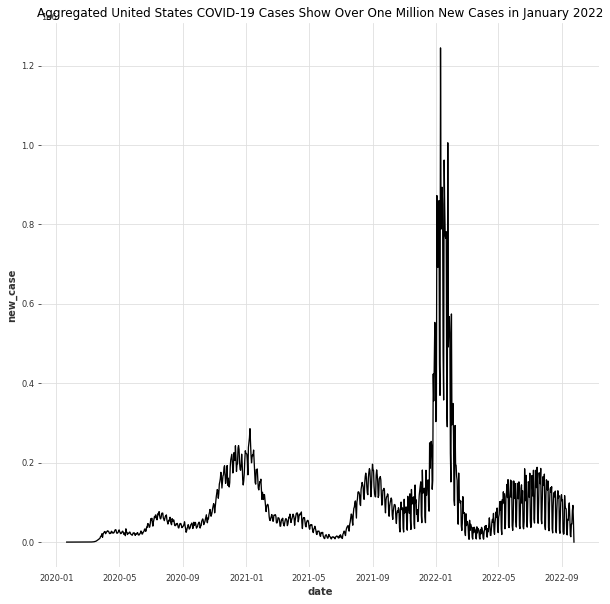

In [15]:
plt.subplots(figsize=(10,10))
sns.lineplot(x='date', y='new_case', data=agg_covid_df_date)
plt.title('Aggregated United States COVID-19 Cases Show Over One Million New Cases in January 2022')
plt.show()

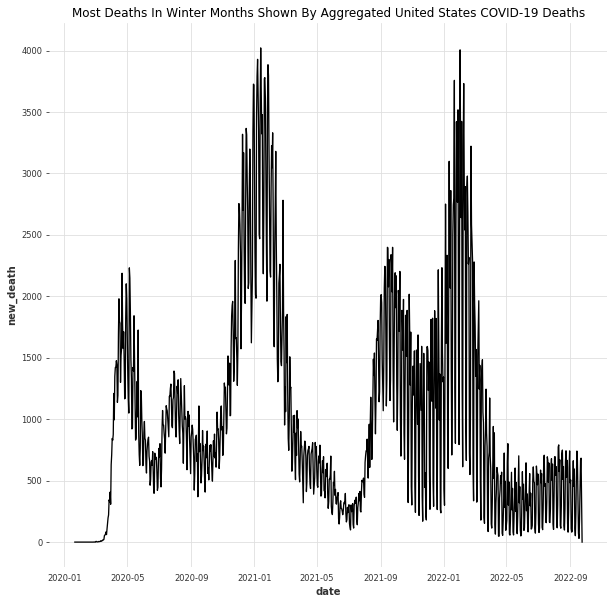

In [16]:
plt.subplots(figsize=(10,10))
sns.lineplot(x='date', y='new_death', data=agg_covid_df_date)
plt.title('Most Deaths In Winter Months Shown By Aggregated United States COVID-19 Deaths')
plt.show()

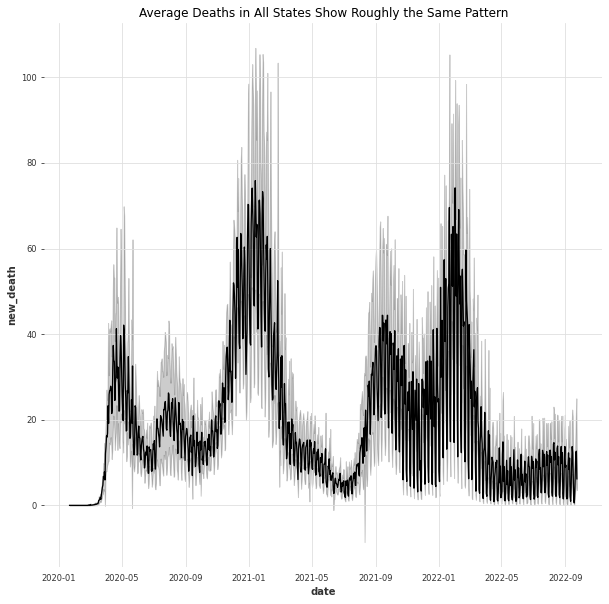

In [17]:
plt.subplots(figsize=(10,10))
sns.lineplot(x='date', y='new_death', data=covid_df)
plt.title("Average Deaths in All States Show Roughly the Same Pattern")
plt.show()

## 3.3 Modeling

### 3.3.1 Transforming the Data


To adjust for the Vaccination data switching from daily recordings to weekly, I will impute the missing values with the last previously known value. I chose to fill with the last known values due to those columns being running totals and not individual daily reports. Using the 'ffill' method for the fillna() method, I can fill the missing gaps in recordings with the previously known valid entry. I fill the initial entries before the vaccine began distribution and began having valid entries with 0.

In [18]:
agg_covid_df_date.fillna(method='ffill', inplace=True)
agg_covid_df_date.fillna(0, inplace=True)
agg_covid_df_date.isnull().sum()

critical_staffing_shortage_today_yes                      0
critical_staffing_shortage_today_no                       0
critical_staffing_shortage_today_not_reported             0
critical_staffing_shortage_anticipated_within_week_yes    0
critical_staffing_shortage_anticipated_within_week_no     0
inpatient_beds_used_covid                                 0
inpatient_beds_used_covid_coverage                        0
previous_day_admission_adult_covid_confirmed              0
previous_day_admission_adult_covid_confirmed_coverage     0
previous_day_admission_adult_covid_suspected              0
previous_day_admission_adult_covid_suspected_coverage     0
distributed                                               0
admin                                                     0
administered_j                                            0
administered_m                                            0
administered_p                                            0
total_admin                             

In [19]:
agg_covid_df_date.reset_index(inplace=True)

### 3.3.2 Creating a Naive Baseline

We create a Naive baseline to compare all our future models to. We use the naive_seasonal() function from the Darts library to create this.

To properly use the Darts library for timeseries forecasting, I transform our dataframe into a timeseries object.

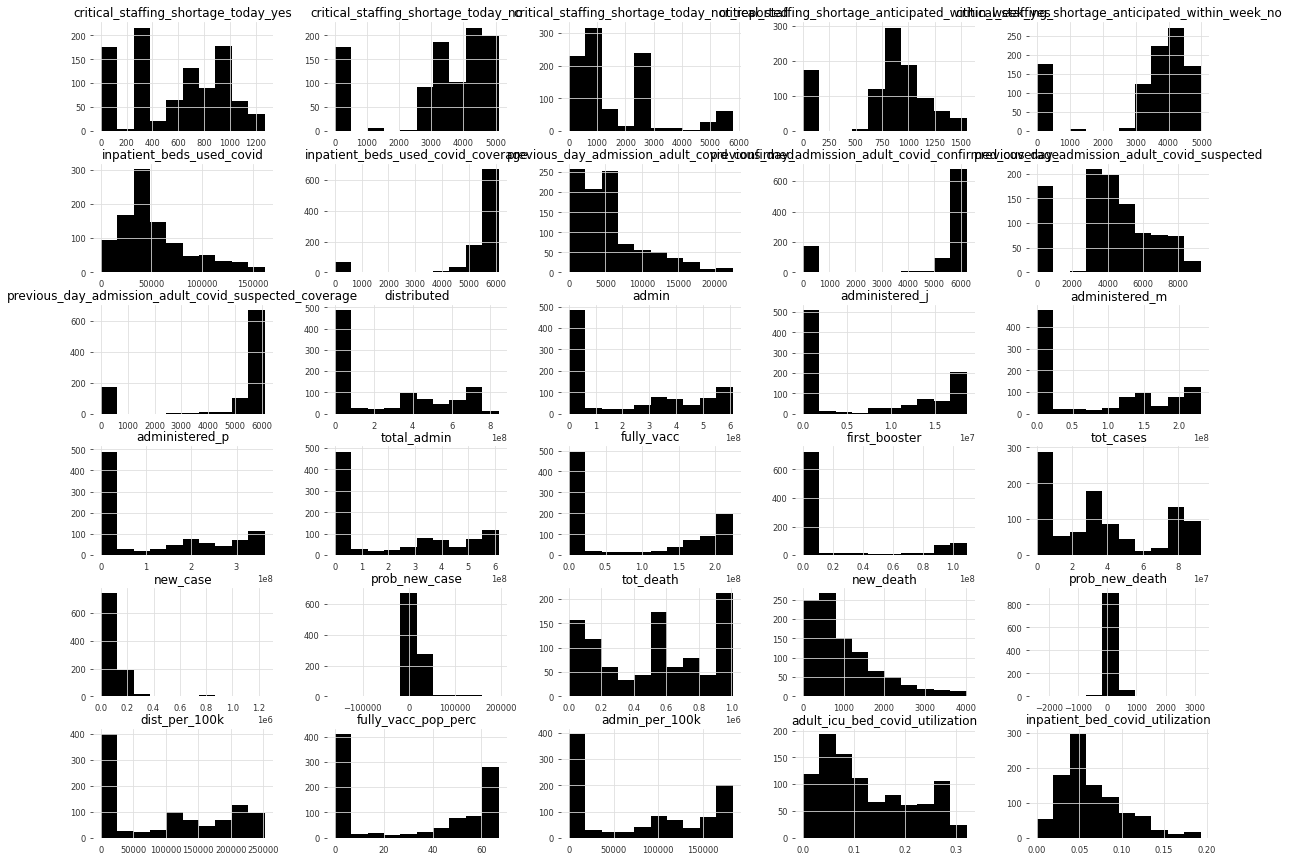

In [20]:
agg_covid_df_date.drop('date', axis=1).hist(figsize=(20,15))
plt.show()

In [21]:
covid_timeseries = TimeSeries.from_dataframe(agg_covid_df_date, time_col='date', 
                                             value_cols='new_case', 
                                             fill_missing_dates=False, freq='D')

I use the Darts TimeSeries method **.split_before()** to create a training and test split to test our model on new data.

The purpose of splitting the timeseries data this way is to train the model on the training data and use that model to make a forecasted prediction. We then judge the prediction from the training data to the testing data.

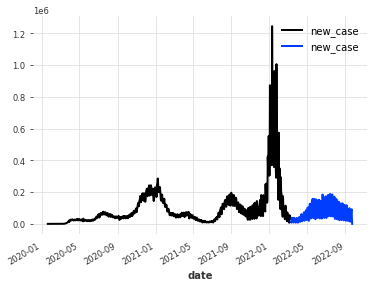

In [22]:
training, testing = covid_timeseries.split_before(0.80)
training.plot()
testing.plot()

I create a NaiveSeasonal model to create a baseline to compare my more complicated future models.

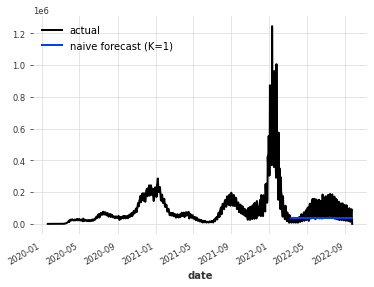

In [23]:
naive_model = NaiveSeasonal(K=1)
naive_model.fit(training)
naive_forecast = naive_model.predict(len(testing))

covid_timeseries.plot(label="actual")
naive_forecast.plot(label="naive forecast (K=1)")

In [24]:
for m in range(2, 25):
    is_seasonal, period = check_seasonality(training, m=m, alpha=0.05)
    if is_seasonal:
        print("There is seasonality of order {}.".format(period))

There is seasonality of order 3.
There is seasonality of order 7.
There is seasonality of order 10.
There is seasonality of order 14.
There is seasonality of order 17.
There is seasonality of order 21.


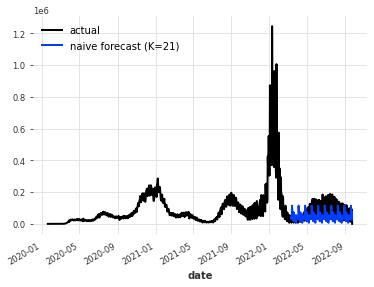

In [25]:
seasonal_model = NaiveSeasonal(K=21)
seasonal_model.fit(training)
seasonal_forecast = seasonal_model.predict(len(testing))

covid_timeseries.plot(label="actual")
seasonal_forecast.plot(label="naive forecast (K=21)")

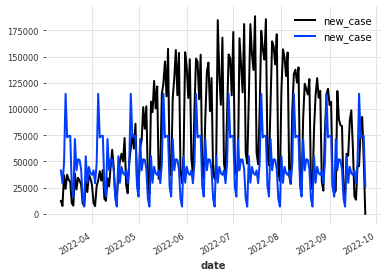

In [26]:
testing.plot()
seasonal_forecast.plot()

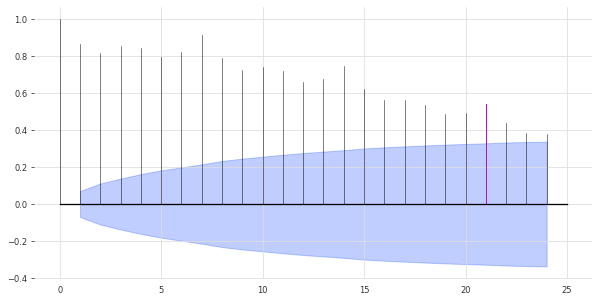

In [27]:
plot_acf(training, m=21, alpha=0.05)

I chose to use **Mean Absolute Scaled Error (mase)** over Mean Absolute Percentage Error (mape) as the metric to evaluate my models due to the data having zero values. This is due to, for example, the time before the vaccine was created and the number of vaccines administered was zero.

If we have zero values and attempt to use mape, we will receive an error. The mean absolute scaled error is also unaffected by scale, which is beneficial for the Covid-19 data that features multiple columns.

In [28]:
error = mase(covid_timeseries, seasonal_forecast, training)

print("Mean absolute scaled error: {:.2f}.".format(error))

Mean absolute scaled error: 2.03.


In [29]:
md(f'''The Mean Absolute Scaled Error for my baseline model is  **{error:.2f}**.

This is our Naive baseline and we begin to create and tune future 
models to predict with a mean absolute scaled error of less.''')

The Mean Absolute Scaled Error for my baseline model is  **2.03**.

This is our Naive baseline and we begin to create and tune future 
models to predict with a mean absolute scaled error of less.

### 3.3.3 Forecasting with Darts Library built in models

I first test the default models built into the darts library.

Exponential Smoothing is a method for predicting univariate time series data (it focuses on just one variable, in this case, time). It predicts based off a weighted linear sum of past values, but gives an exponentially lower weight to further past values.

TBATS is a method that uses Exponential Smoothing, but its main focus is to fit with data with complex seasonal trends.

ARIMA (AutoRegressive Integrated Moving Average) is regressive, meaning it makes judgements based on past values and assumes that the future will resemble the past. It uses lagged moving averages to smoothen the data.

AutoARIMA searches for the best ARIMA model based on restaints provided.

We initially test the default libraries to see which model gets the best MASE value.

In [30]:
def eval_model(model):
    '''
    This function's purpose is to fit the provided model with the training data set,
    creating a forecast of the remaining dates, and plotting the forecast over
    the entire covid_timeseries
    '''
    model.fit(training)
    forecast = model.predict(len(testing))
    covid_timeseries.plot()
    forecast.plot()
    print("model {} obtains MASE: {:.2f}".format(model, mase(covid_timeseries, forecast, training)))

C:\Users\Tonis\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


model ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7 obtains MASE: 9.98
model (T)BATS obtains MASE: 3.01
model ARIMA(12, 1, 0) obtains MASE: 2.96
model Auto-ARIMA obtains MASE: 2.38


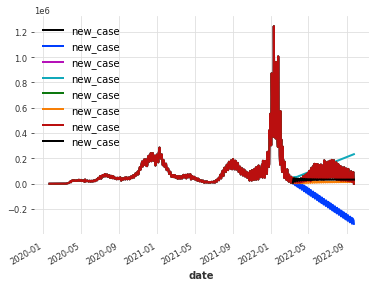

In [31]:
eval_model(ExponentialSmoothing())
eval_model(TBATS())
eval_model(ARIMA())
eval_model(AutoARIMA())

These models are performing at a higher (less accurate) MASE than my baseline model, so I choose to try more complex models to fit my data.

### 3.3.4 Modeling with RandomForest and HistGradientBoost

Multivariate timeseries data consists of more than one dependent variable. I create TimeSeries data from the features chosen in the EDA notebook to use as Past Covariates.

We also create a timeseries featuring the month and year as features to use as future covariates (data that is known about the future predictions).

In [32]:
hosp_staff = TimeSeries.from_dataframe(agg_covid_df_date, time_col='date', 
                                             value_cols='critical_staffing_shortage_today_yes', 
                                             fill_missing_dates=False, freq='D')
inpatient_beds = TimeSeries.from_dataframe(agg_covid_df_date, time_col='date', 
                                             value_cols='inpatient_beds_used_covid', 
                                             fill_missing_dates=False, freq='D')
fully_vacc = TimeSeries.from_dataframe(agg_covid_df_date, time_col='date', 
                                             value_cols='fully_vacc_pop_perc', 
                                             fill_missing_dates=False, freq='D')
admin = TimeSeries.from_dataframe(agg_covid_df_date, time_col='date', 
                                             value_cols='admin_per_100k', 
                                             fill_missing_dates=False, freq='D')
prev_cov_confirm = TimeSeries.from_dataframe(agg_covid_df_date, time_col='date', 
                                             value_cols='previous_day_admission_adult_covid_confirmed', 
                                             fill_missing_dates=False, freq='D')

past_covs = concatenate([hosp_staff, inpatient_beds, fully_vacc,
                        admin, prev_cov_confirm], axis='component')

In [33]:
covid_covs = concatenate(
    [
        datetime_attribute_timeseries(covid_timeseries.time_index, "month", dtype=np.float32) / 12,
        (datetime_attribute_timeseries(covid_timeseries, "year", dtype=np.float32) - 1948) / 12,
    ],
    axis="component",
)

I start with a RandomForest model, which with default parameters, gets an MASE that is already better than our baseline model.

In [34]:
randfor_model = RegressionModel(lags=72, lags_past_covariates=[-6, -1], lags_future_covariates=[-6, 0], model=RandomForestRegressor(random_state=0))
randfor_model.fit(series=training, past_covariates=past_covs, future_covariates=covid_covs)
forecast = randfor_model.predict(len(testing))
print("model {} obtains MASE: {:.2f}".format(randfor_model, mase(covid_timeseries, forecast, training)))

model RandomForestRegressor(random_state=0) obtains MASE: 1.96


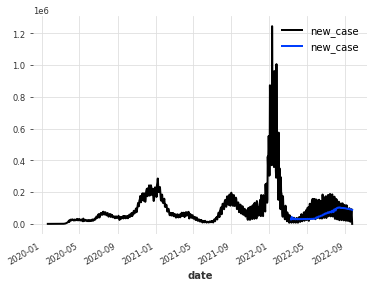

In [35]:
covid_timeseries.plot()
forecast.plot()
plt.show()

The next model I chose to use is a HistGradientModel. Hist Gradient Models is an ensemble of decision trees and can handle null values.

In [36]:
histgrad_model = RegressionModel(lags=72, lags_past_covariates=[-6, -1], lags_future_covariates=[-4, 0], model=HistGradientBoostingRegressor())
histgrad_model.fit(series=training, past_covariates=past_covs, future_covariates=covid_covs)
forecast = histgrad_model.predict(len(testing))
print("model {} obtains MASE: {:.2f}".format(histgrad_model, mase(covid_timeseries, forecast, training)))

model HistGradientBoostingRegressor() obtains MASE: 1.65


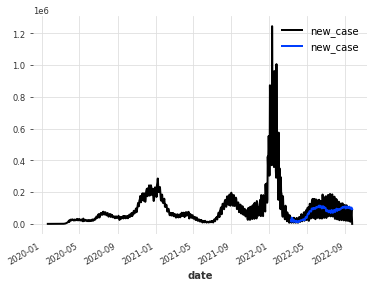

In [37]:
covid_timeseries.plot()
forecast.plot()
plt.show()

In [38]:
histgrad_model = RegressionModel(lags=72, lags_past_covariates=[-6, -1], lags_future_covariates=[-4, 0], model=HistGradientBoostingRegressor())
histgrad_model.fit(series=training, past_covariates=past_covs, future_covariates=covid_covs)
forecast = histgrad_model.predict(len(testing))
print("model {} obtains MASE: {:.2f}".format(histgrad_model, mase(covid_timeseries, forecast, training)))

model HistGradientBoostingRegressor() obtains MASE: 1.65


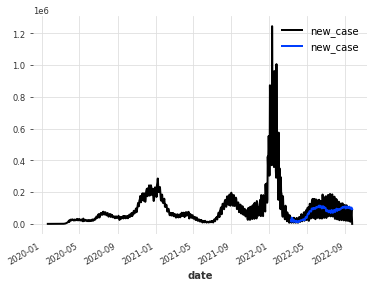

In [39]:
covid_timeseries.plot()
forecast.plot()
plt.show()

The HistGradientBoosting model gave me the lowest mase of the rest of the data and will be used to predict my future new_case data. Unfortunately, the MASE I was hoping for was one under 1.0, as any value above 1 means that the model needs work. However, I will use this model to forecast the next 90 days of values for my data visualization.

### 3.3.5 Predicting Future New Cases

I create new past and future covariates to include date values for the next 90 days from the last day recorded.

These new covariates are entered into a HistGradientModel and the predicted data plotted with the entire covid_timeseries dataset.

In [40]:
start_date = covid_df['date'].min()
present_date = covid_df['date'].max() + datetime.timedelta(1)
end_date = covid_df['date'].max() + datetime.timedelta(365)

In [41]:
temp_array = [[pd.NaT]*5]*365

In [42]:
predict_past_cov = past_covs.append_values(temp_array)

In [43]:
additional_time = constant_timeseries(value=0, start=start_date, end=end_date, freq='D', column_name='date')
additional_time_df = additional_time.pd_dataframe()
additional_time_df.tail()

component,date
time,
2023-09-20,0.0
2023-09-21,0.0
2023-09-22,0.0
2023-09-23,0.0
2023-09-24,0.0


In [44]:
additional_time = concatenate(
    [
        datetime_attribute_timeseries(additional_time.time_index, "month", dtype=np.float32) / 12,
        (datetime_attribute_timeseries(additional_time, "year", dtype=np.float32) - 1948) / 12,
    ],
    axis="component",
)

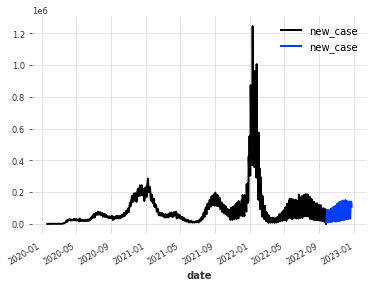

In [45]:
histgrad_model2 = RegressionModel(lags=72, lags_past_covariates=[-6, -1], lags_future_covariates=[-4, 0], model=HistGradientBoostingRegressor())
histgrad_model2.fit(series=covid_timeseries, past_covariates=predict_past_cov, future_covariates=additional_time)
forecast = histgrad_model2.predict(90) 
covid_timeseries.plot()
forecast.plot()

In [46]:
covid_predicted_forecast = forecast.pd_dataframe()

## 3.4 Data Export to Google Sheets

Using a library called *gspread_pandas*, we can take a Pandas DataFrame and export it to a connected Google Sheets file. By doing this, we can connect this google sheets file to our Public version of Tableau for data analysis and visualization.

By connecting this jupyter notebook with a specific Google Sheets file, we can export both our actual values and our forecasted values to separate sheets of the notebook in almost real time. Each time these notebooks are ran, they'll extract the CSV directly from the sources, clean them, and create a forecast on the new data. Tableau updates daily from Google Drive so we'll get visualizations that update each time I rerun these notebooks.

The *gspread_pandas* library can be found at the link below:
<br>[gspread_pandas documentation](<https://github.com/aiguofer/gspread-pandas>)

In [47]:
# The following code is to set the gspread_pandas config directory and file name to connect to the google sheets. 
# The .get_config() function will return the private client token that connects to a specific sheet in my connected account

#gspread_pandas.conf.get_config

### 3.4.1 Cleaned Covid-19 DataFrame to Import into Google Sheets

In [48]:
spread = gspread_pandas.Spread('COVID-19 Spreadsheet')

In [49]:
spread.df_to_sheet(covid_df, index=False, sheet='Cleaned_Data', start='A2', replace=True)

In [50]:
spread.sheets

[<Worksheet 'Cleaned_Data' id:673492038>,
 <Worksheet 'Forecast' id:17890723>,
 <Worksheet 'Population Info' id:761376139>]

### 3.4.2 New Case and New Death Forecasted Data

In [51]:
covid_predicted_forecast.reset_index(inplace=True)

In [52]:
covid_predicted_forecast.head()

component,date,new_case
0,2022-09-25,9860.691517
1,2022-09-26,46753.065971
2,2022-09-27,57786.176099
3,2022-09-28,79656.204699
4,2022-09-29,87824.173499


In [53]:
spread.df_to_sheet(covid_predicted_forecast, index=False, sheet='Forecast', start='A2', replace=True)

### 3.4.3 Population Data to Import into Google Sheets

To use in our tableau dashboard, I will also import state population data from The United States Census. This data will be used to calculate per capita measurements to properly compare new Covid-19 cases and deaths per state.

[Link to State Census Data](https://www2.census.gov/programs-surveys/popest/datasets/2020-2021/state/totals/)


In [54]:
state_pop_data = pd.read_csv('https://www2.census.gov/programs-surveys/popest/datasets/2020-2021/state/totals/NST-EST2021-alldata.csv')

In [55]:
state_pop_data

,SUMLEV,REGION,DIVISION,STATE,NAME,ESTIMATESBASE2020,POPESTIMATE2020,POPESTIMATE2021,NPOPCHG_2020,NPOPCHG_2021,...,NETMIG2020,NETMIG2021,RESIDUAL2020,RESIDUAL2021,RBIRTH2021,RDEATH2021,RNATURALINC2021,RINTERNATIONALMIG2021,RDOMESTICMIG2021,RNETMIG2021
0,10,0,0,0,United States,331449281,331501080,331893745,51799,392665,...,12247,244622,0,0,10.798957,10.352637,0.446319,0.737485,0.000000,0.737485
1,20,1,0,0,Northeast Region,57609148,57525633,57159838,-83515,-365795,...,-79429,-333592,-1024,-1151,9.950554,10.492070,-0.541516,0.977386,-6.794897,-5.817511
2,20,2,0,0,Midwest Region,68985454,68935174,68841444,-50280,-93730,...,-47266,-85268,-718,5156,10.860566,11.058248,-0.197682,0.549222,-1.786994,-1.237772
3,20,3,0,0,South Region,126266107,126409007,127225329,142900,816322,...,134454,770076,528,-3385,11.168835,10.777476,0.391359,0.886268,5.186064,6.072332
4,20,4,0,0,West Region,78588572,78631266,78667134,42694,35868,...,4488,-106594,1214,-620,10.767153,8.947910,1.819243,0.487570,-1.842880,-1.355309
5,40,3,6,1,Alabama,5024279,5024803,5039877,524,15074,...,3337,23380,-75,242,11.191613,12.890226,-1.698613,0.247201,4.398749,4.645950
6,40,4,9,2,Alaska,733391,732441,732673,-950,232,...,-2012,-3353,39,-54,12.667956,7.700425,4.967532,0.718033,-5.295151,-4.577118
7,40,4,8,4,Arizona,7151502,7177986,7276316,26484,98330,...,26791,97504,-3,-6,10.584669,10.469547,0.115121,0.619608,12.871739,13.491347
8,40,3,7,5,Arkansas,3011524,3012232,3025891,708,13659,...,1618,16840,-15,55,11.599962,12.671819,-1.071856,0.272932,5.304960,5.577892
9,40,4,9,6,California,39538223,39499738,39237836,-38485,-261902,...,-62562,-352960,858,-938,10.778412,8.441637,2.336775,0.364223,-9.329701,-8.965478


In [56]:
spread.df_to_sheet(state_pop_data, index=False, sheet='Population Info', start='A2', replace=True)

## 4.1 Continuation

The previously collected cleaned and analyzed data will be visually presented on a Tableau Dashboard that can be accessed on computer or mobile at the following link:

[Link to Tableau Page](https://public.tableau.com/app/profile/tony.tran2362/viz/COVID-19Data_16637479536980/ReportedCOVID-19CasesandDeathsIntheUnitedStatesTracker)